In [1]:
from typing import TypedDict, Optional

class MyState(TypedDict):
    user_query: str
    rewritten_query: Optional[str]
    need_internet_search: Optional[bool]
    search_results: Optional[str]
    final_answer: Optional[str]
    bad_state: Optional[bool]
    query_intent: Optional[str]
    user_phone_num: Optional[str]
    user_order_id: Optional[str]
    order_operation: Optional[str]
    previous_chats_summary: Optional[str]

In [2]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the environment variable
together_api = os.environ.get('TOGETHER_API_KEY')

from langchain_openai import ChatOpenAI

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"

llm = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=together_api
)

In [3]:
def node_query_rewrite(state: MyState) -> MyState:
    """
    Rewrites the user's query using an LLM for clarity or correctness.
    Sanitizes the rewritten query to ensure compatibility with the search engine.
    """
    print("---Node Query Rewrite---")
    user_query = state["user_query"]
    
    # Prompt to rewrite the query
    rewrite_prompt = f"Please rewrite this query suitable for search engines. Ensure it is clear and concise:\n\n{user_query}"
    
    # Invoke the LLM to rewrite the query
    rewritten = llm.invoke(rewrite_prompt).content
    print("Raw rewritten query from LLM:", rewritten)
    
    # Sanitize the rewritten query
    def sanitize_query(query: str) -> str:
        import re
        # Allow only alphanumeric characters, spaces, and basic punctuation (e.g., single quotes, dashes)
        return re.sub(r'[^a-zA-Z0-9\s\'-]', '', query).strip()
    
    sanitized_query = sanitize_query(rewritten)
    print("Sanitized query:", sanitized_query)
    
    # Update the state with the sanitized query
    state["rewritten_query"] = sanitized_query
    return state

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage
import nest_asyncio
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import pandas as pd


embedding_model = get_registry().get(
    "sentence-transformers").create(name="BAAI/bge-small-en-v1.5")


class ChunksOfData(LanceModel):
    id_: str
    text: str = embedding_model.SourceField()  # Store text data for search
    metadata_file_name: str
    metadata_creation_date: str
    metadata_pagenumber: int
    vector: Vector(embedding_model.ndims()
                   ) = embedding_model.VectorField()  # type: ignore


def df_to_dict_batches(df: pd.DataFrame, batch_size: int = 128):
    """
    Yields data from a DataFrame in batches of dictionaries.
    Each batch is a list of dict, suitable for LanceDB ingestion.
    """
    for start_idx in range(0, len(df), batch_size):
        end_idx = start_idx + batch_size
        # Convert the batch of rows to a list of dict
        batch_dicts = df.iloc[start_idx:end_idx].to_dict(orient="records")
        yield batch_dicts


nest_asyncio.apply()
db = lancedb.connect(".lancedb")

# Check if the table already exists in the database
if "embedded_chunks3" in db.table_names():
    tbl = db.open_table("embedded_chunks3")
    print("Table 'embedded_chunks3' loaded successfully.")

else:
    print("Table 'embedded_chunks3' not found. Creating a new one...")
    pdf_files = ["../assets/The New Complete Book of Foos.pdf"]
    llama_pase_api = os.environ.get("LLAMA_PARSE_API_KEY")

    parser = LlamaParse(result_type="text", api_key=llama_pase_api)
    file_extractor = {".pdf": parser}
    data_for_parse = SimpleDirectoryReader(
        input_files=pdf_files, file_extractor=file_extractor)
    documents = data_for_parse.load_data()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1024,
        chunk_overlap=64,
        length_function=len,
        is_separator_regex=False,
    )

    documents_list = []
    page_number = 0
    last_doc = None
    for doc in documents:
        if last_doc is None or last_doc != doc.metadata["file_name"]:
            page_number = 1
            last_doc = doc.metadata["file_name"]
        else:
            page_number += 1

        texts = text_splitter.split_text(doc.text)
        for text in texts:
            item = {}
            item["id_"] = doc.id_
            item["text"] = text
            item["metadata_file_name"] = doc.metadata["file_name"]
            item["metadata_creation_date"] = doc.metadata["creation_date"]
            item["metadata_pagenumber"] = page_number
            documents_list.append(item)
    df = pd.DataFrame(documents_list)
    tbl = db.create_table(
        "embedded_chunks3",
        data=df_to_dict_batches(df, batch_size=10),
        schema=ChunksOfData,
    )
    tbl.create_fts_index("text")
    print("Table 'embedded_chunks3' created successfully.")

/home/davinci/GitHub/JANJAN/lxms/apps/chatfood/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Table 'embedded_chunks3' loaded successfully.


In [5]:
def node_search_book(state: MyState) -> MyState:
    """
    search from the book
    """
    print("---Node Search the book---")
    query = state["rewritten_query"]
    
    context_list = tbl.search(query, query_type="hybrid").limit(5).to_list()
    context = ''.join([f"{c['text']}\n\n" for c in context_list])
    
    system_prompt = "Answer user query based on the given context.if context is not related, just write: unrelated"
    user_prompt = f"Question:\n{query}\nContext:\n{context}"

    messages = [
        SystemMessage(system_prompt),
        HumanMessage(user_prompt),
    ]
    
    results = llm.invoke(messages)
    
    if results.content.lower() == "unrelated":
        state["need_internet_search"] = True
    else:
        state["need_internet_search"] = False
        state['search_results'] = results
    
    return state


from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api = os.environ.get("TAVILY_API_KEY")


def node_search_internet(state: MyState) -> MyState:
    """
    Searches the internet for the rewritten query using a search tool.
    """
    if state.get("need_internet_search", False):
        print("---Node Search Internet---")
        rewritten_query = state["rewritten_query"]
    
        # Use your search tool function
        results = TavilySearchResults(max_results=3, tavily_api_key=tavily_api).invoke(rewritten_query)
        print("Search results:")
        print(results)
        # Save the search results in state
        state["search_results"] = str(results)
        
    return state


def node_generate_answer(state: MyState) -> MyState:
    """
    Generates a final answer based on the original user query and the search results.
    """
    print("---Node Generate Answer---")
    user_query = state["user_query"]
    search_info = state.get("search_results", "No search results found.")
    # search_info = state["search_results"] or "No search results found."
    # Combine user query with search results to generate answer
    try:
        
        if not state["bad_state"]:
            final_answer = llm.invoke(
                f"User's query: {user_query}\n\nSearch results:\n{search_info}\n\n"
                "Please provide a helpful answer."
            )
            state["final_answer"] = final_answer.content
        
        
        else:
            print("sorry i can't give services.")
            state["final_answer"] = "Not related Query!"
    except Exception as e:
        print(f"Error during answer generation: {e}")
        state["final_answer"] = "Sorry, there was an issue generating the answer."
    return state

In [6]:
from typing import Literal
from pydantic import BaseModel, Field

class IsRelated(BaseModel):
    reasoning: str = Field(description="The reasoning behind the decision, whether the query is related to restaurants and foods or not.")
    is_related_flag: bool = Field(description="The decision whether the query is related to restaurants and foods or not.")

def is_related(state: MyState) -> Literal["node_intent_identifier", "node_check_further"]:
    query = state["user_query"]
    llm_with_structured_output = llm.with_structured_output(IsRelated)
    try:
        prompt = (
            f"Analyze the following query and decide whether it is related to restaurants or foods. "
            "Respond in this exact JSON format: "
            '{"reasoning": "<reasoning string>", "is_related_flag": <true|false>}.\n\n'
            f"Query: {query}"
        )
        
        response = llm_with_structured_output.invoke(prompt)
        if response and hasattr(response, 'is_related_flag') and isinstance(response.is_related_flag, bool):
            print("-----Is Related-----")
            print(response)
            if response.is_related_flag:
                return "node_intent_identifier"
            else:
                return "node_check_further"  # A node to update `bad_state`
        else:
            print("Invalid response structure.")
            return "node_check_further"
    except Exception as e:
        print(f"Error invoking LLM: {e}")
        return "node_update_bad_state"
    
def node_update_bad_state(state: MyState) -> MyState:
    """
    Updates the state to indicate a 'bad state' when the query is not related.
    """
    state["bad_state"] = True
    return state

In [7]:
def function_switcher(state: MyState) -> Literal["node_query_rewrite", "node_order_operation", "node_searching_food", "node_food_analysis"]:
    """
    Determines the next node based on the intent identified in the state.
    """
    query_intent = state.get("query_intent", None)  # Retrieve the intent from the state
    
    if query_intent == "general_food":
        return "node_query_rewrite"  # Route to the general query handling node
    elif query_intent == "order_operation":
        return "node_order_operation"  # Route to the order operation handling node
    elif query_intent == "search_food_restaurant":
        return "node_searching_food"
    elif query_intent == "food_analysis_suggest":
        return "node_food_analysis"
    else:
        raise ValueError("Unknown or missing query intent in state.")  # Handle unexpected cases

In [8]:
def node_intent_identifier(state: MyState):
    query = state['user_query']
    
    print("--- INTENT IDENTIFY ---")
    prompt = f"""
    Determine the intent of the given query based on the user's purpose.

    ### Query:
    {query}

    ### Instructions:
    - If the query is about general questions related to food (e.g., what a food is, how it is made), respond with **general_food**.
    - If the query is about making, tracking, or modifying orders, respond with **order_operation**.
    - If the query is about searching for food or restaurants (e.g., "Find pizza near me, or price of food"), respond with **search_food_restaurant**.
    - If the query requests food suggestions based on **taste preferences**, **ingredients**, **dietary needs**, or **deep culinary analysis** (e.g., "spicy Spanish food with chorizo and paprika"), respond with **food_analysis_suggest**.

    ### Additional Scenarios:
    1. If the user asks for a dish/recipe tailored to specific flavors, textures, or cultural fusion (e.g., "I want tangy vegan Asian fusion dishes"), use **food_analysis_suggest**.
    2. If the user includes descriptors like "spicy," "creamy," "gluten-free," or "authentic regional flavors," use **food_analysis_suggest**.
    3. For ambiguous queries like "I want pizza," default to **search_food_restaurant**. Only use **food_analysis_suggest** when specific criteria are provided.

    ### Response:
    Respond with only one of the following:  
    - **general_food**  
    - **order_operation**
    - **search_food_restaurant**
    - **food_analysis_suggest**
    Do not provide explanations, markdown, or extra text. just write final answer without any markdown!
    """
    
    result = llm.invoke(prompt)
    
    if result.content.lower() == 'general_food':
        state['query_intent'] = 'general_food'
    if result.content.lower() == 'order_operation':
        state['query_intent'] = 'order_operation'
    if result.content.lower() == 'search_food_restaurant':
        state['query_intent'] = 'search_food_restaurant'
    if result.content.lower() == 'food_analysis_suggest':
        state['query_intent'] = 'food_analysis_suggest'
    
    return state

In [9]:
import json
from db_manager import food_search

def node_searching_food(state: MyState):
    print("------------ node search food ---------------------")
    query = state['user_query']
    prompt = f"""
    Your task is to extract the food name and restaurant name from the given query. If a food name or restaurant name is not explicitly mentioned, return null for that field. 
    
    Do not provide any explanations, examples, or additional text. Output **only** the JSON response. Follow the format strictly.
    
    Query:
    {query}
    
    Respond in this exact JSON format:
    {{
      "food_name": "<extracted food name or null>",
      "restaurant_name": "<extracted restaurant name or null>"
    }}
    
    dont write any explanation. just write JSON and not more!
    """
    
    llm_response = llm.invoke(prompt).content
    response_data = json.loads(llm_response)
    food_name = response_data.get("food_name", None)
    restaurant_name = response_data.get("restaurant_name", None)
    matches = food_search(food_name, restaurant_name)
    prompt2 = f"""
    You are assisting a customer by providing a clear and concise response based on the matched search results I provide. 

    ### Task:
    - Use the provided list of matches to generate a natural and conversational response for the customer.
    - Highlight the key details of the matched items without including any unnecessary information.
    - Organize the information logically and ensure it is easy for the customer to understand.

    ### Matches:
    {matches}

    ### Instructions:
    - Focus on addressing the customer's needs directly.
    - Avoid providing extra explanations or irrelevant details.
    - Write the response as if you were directly speaking to the customer.
    """
    
    results = llm.invoke(prompt2).content
    
    state["final_answer"] = results
    
    prompt = f"""
    You are an expert at rewriting user queries to make them clearer, more specific, and easier to understand for other language models. Your task is to analyze the user's query and rewrite it in a way that improves its clarity and context.

    **Instructions**:
    1. Read the user's query carefully.
    2. Identify the intent and key details in the query.
    3. Rewrite the query to make it more concise, specific, and unambiguous.
    4. Ensure the rewritten query retains the original meaning but is easier for other language models to process.
    5. If the query is already clear and specific, return it as-is.

    **Rules**:
    - Do not add any extra information that was not in the original query.
    - Do not remove any key details from the original query.
    - Keep the rewritten query concise and to the point.

    **Examples**:
    1. Original Query: "What's the weather?"
       Rewritten Query: "What is the current weather in my location?"

    2. Original Query: "Tell me about AI."
       Rewritten Query: "Can you provide an overview of artificial intelligence, including its history and applications?"

    3. Original Query: "How do I fix my computer?"
       Rewritten Query: "What are the steps to troubleshoot and fix common computer issues?"

    **Input**:
    User Query: "{query}"

    **Output**:
    Rewritten Query: 
        """
    
    response = llm.invoke(prompt)
    state['rewritten_query'] = response.content
    
    return state
    

In [10]:
import re

def node_extract_info_from_user_query(state: MyState):
    print("------------- getting info from user -------------------")
    inputs_are_ok = False
    query = ""
    validated_phone_number = ""
    validated_order_id = ""
    print("please enter your phone number: (10 digit)")
    phone_num = input()
    query += "phone_number: " + phone_num + "\n"
    print("and also please enter your order id:")
    order_id = input()
    query += "order_id: " + order_id

    extractor_prompt = f"""Extract the phone number and order ID from the query.\n query: \n{query}\n\n 
    Validate the phone number to ensure it is in a valid format (e.g., 10 digits for standard phone numbers). 
    Validate the order ID to ensure it meets the required format (e.g., alphanumeric, specific length). 
    Return the output in the format: phone_number-order_id. If either the phone number or order ID is invalid, 
    return invalid for that field. do not write explanation or anything more."""

    extraction_result = llm.invoke(extractor_prompt)
    pattern = r"^(?P<phone_number>(\d{10}|invalid))-(?P<order_id>([A-Za-z0-9]+|invalid))$"
    match = re.match(pattern, extraction_result.content)
    if match:
        validated_phone_number = match.group("phone_number")
        validated_order_id = match.group("order_id")
        if validated_phone_number != 'invalid' and validated_order_id != 'invalid':
                inputs_are_ok = True

    
    while not inputs_are_ok:
        query = ""
        print("Your input is not valid, be careful and enter again:")
        print("enter phone number: ")
        phone_num = input()
        query += "phone_number: " + phone_num + "\n"
        print("enter order id: ")
        order_id = input()
        query += "order_id: " + order_id
        extractor_prompt = f"""Extract the phone number and order ID from the query.\n query: \n{query}\n\n 
        Validate the phone number to ensure it is in a valid format (e.g., 10 digits for standard phone numbers). 
        Validate the order ID to ensure it meets the required format (e.g., alphanumeric, specific length). 
        Return the output in the format: phone_number-order_id. If either the phone number or order ID is invalid, 
        return invalid for that field. do not write explanation or anything more."""
        extraction_result = llm.invoke(extractor_prompt)
        match = re.match(pattern, extraction_result.content)
        if match:
            validated_phone_number = match.group("phone_number")
            validated_order_id = match.group("order_id")
            if validated_phone_number != 'invalid' and validated_order_id != 'invalid':
                inputs_are_ok = True
    
    
    state["user_phone_num"] = validated_phone_number
    state["user_order_id"] = validated_order_id
    
    return state

In [55]:
from db_manager import *

def node_order_operation(state: MyState):
    query = state['user_query']
    print("------------ node order operation --------------------")
    prompt = f"""You are a switcher. Based on the user query, determine which function should be called. The available functions are:

                comment_order(order_id, person_name, comment): Use this if the query is about adding a comment to an order.

                check_order_status(order_id): Use this if the query is about checking the status of an order.

                cancel_order(order_id, phone_number): Use this if the query is about canceling an order.
                
                query: {query}

                Analyze the query and respond with only the name of the appropriate function. Do not include any additional text or explanation."""
    
    result = llm.invoke(prompt).content
    
    
    if result == "comment_order":
        state['order_operation'] = "comment_order"
    if result == "check_order_status":
        state["order_operation"] = "check_order_status"
    if result == "cancel_order":
        state["order_operation"] = "cancel_order"
        
    
    prompt = f"""
    You are an expert at rewriting user queries to make them clearer, more specific, and easier to understand for other language models. Your task is to analyze the user's query and rewrite it in a way that improves its clarity and context.

    **Instructions**:
    1. Read the user's query carefully.
    2. Identify the intent and key details in the query.
    3. Rewrite the query to make it more concise, specific, and unambiguous.
    4. Ensure the rewritten query retains the original meaning but is easier for other language models to process.
    5. If the query is already clear and specific, return it as-is.

    **Rules**:
    - Do not add any extra information that was not in the original query.
    - Do not remove any key details from the original query.
    - Keep the rewritten query concise and to the point.

    **Examples**:
    1. Original Query: "What's the weather?"
       Rewritten Query: "What is the current weather in my location?"

    2. Original Query: "Tell me about AI."
       Rewritten Query: "Can you provide an overview of artificial intelligence, including its history and applications?"

    3. Original Query: "How do I fix my computer?"
       Rewritten Query: "What are the steps to troubleshoot and fix common computer issues?"

    **Input**:
    User Query: "{query}"

    **Output**:
    Rewritten Query: 
        """
    
    response = llm.invoke(prompt)
    state['rewritten_query'] = response.content
        
        
    return state

In [56]:
def node_cancel_order(state: MyState):
    phone_number = state['user_phone_num']
    result = cancel_order(state['user_order_id'], f"{phone_number[:3]}-{phone_number[3:6]}-{phone_number[6:]}")
    print("----- order cancelation --------")
    print(result)
    print("---------------------------------")
    state['final_answer'] = result
    return state


def node_check_order_status(state: MyState):
    result = check_order_status(state['user_order_id'], state['user_phone_num'])
    print("-------------- check order status -----------------------")
    print(result)
    print("-----------------------------------------------------------")
    state['final_answer'] = result
    return state


def node_comment_order(state: MyState):
    print("please enter your name:")
    name = input()
    print("please enter your comment:")
    comment = input()
    result = comment_order(state["user_order_id"], name, comment)
    print("------------------ comment order -------------------------------")
    print(result)
    print("--------------------------------------------------------------")
    state["final_answer"] = result
    return state

In [57]:
def order_operation_switcher(state: MyState)-> Literal["node_cancel_order", "node_check_order_status", "node_comment_order"]:
    order_operation = state['order_operation']
    
    
    if order_operation == "cancel_order":
        return "node_cancel_order"
    if order_operation == "check_order_status":
        return "node_check_order_status"
    if order_operation == "comment_order":
        return "node_comment_order"
    

In [58]:
def node_previous_chat_summarizer(state: MyState):
    previous_chat_summary = state['previous_chats_summary']
    user_query = state['rewritten_query']
    final_answer = state['final_answer']
    print("----------------- SUMMARIZING ---------------------------")
    prompt = f"""
    You are an AI assistant tasked with summarizing the context of a conversation based on the following inputs:

    1. **Previous Chat Summary**: {previous_chat_summary}
    2. **User Query**: {user_query}
    3. **Final Answer**: {final_answer}

    Your task is to generate a concise and coherent summary of the entire conversation, incorporating the key points from the previous chat summary, the user's query, and the final answer. Ensure the summary flows naturally and maintains context for future interactions.

    Guidelines for the Summary:
    - Start by briefly restating the context from the previous chat summary.
    - Highlight the user's query and its intent.
    - Include the final answer or resolution provided.
    - Keep the summary clear, concise, and relevant for future reference.

    Output Format:
    Provide the summary in a single paragraph, written in a neutral and professional tone. just write summary and dont write explanations.
    """
    
    response = llm.invoke(prompt)
    state['previous_chats_summary'] = response.content
    
    return state

In [59]:
def node_check_further(state: MyState):
    """
    this node use previous chat summary for further analysis especially for multi step queries.
    """
    query = state['user_query']
    previous_chats_summary = state['previous_chats_summary']
    
    prompt = f"""
    You are an AI assistant tasked with rewriting a user's query to make it clearer and more understandable, based on the context of previous conversations.

    **Previous Chat Summary**: {previous_chats_summary}
    **User Query**: {query}

    Your task is to:
    1. Determine if the user's query is related to the previous chat summary.
    2. If it is related, rewrite the query to make it more clear and understandable for further processing.
    3. If it is unrelated, return an empty string.
    4. If there is no previous chat summary, return an empty string.

    **Rules**:
    - Only return the rewritten query if the user's query is related to the previous chat summary.
    - If the query is unrelated, return an empty string.
    - Keep the rewritten query concise and focused.

    **Output**:
    - If unrelated: empty string(nothing)
    - If related: The rewritten query
    
    
    So Just write desired output without any explanation and markdown!
    """
    
    response = llm.invoke(prompt)
    state['user_query'] = response.content
    
    return state

In [60]:
def is_further_related(state: MyState) -> Literal["node_intent_identifier", "node_update_bad_state"]:
    if state['user_query'] == "":
        return "node_update_bad_state"
    else:
        return "node_intent_identifier"

# food analysis and recommendation

In [61]:
from db_manager import fetch_all_foods

def all_foods():
    results = fetch_all_foods()
    return [{
            "id": row[0],
            "name": row[1],
            "category": row[2],
            "restaurant": row[3],
            "price": row[4]
        } for row in results]

In [62]:
def search_database(plan):
    """Search database using generated plan"""
    all_items = all_foods()
    filters = []

    # Convert plan to SQL filters
    if "price_range" in plan:
        try:
            min_price = float(plan["price_range"].get("min", 0))
            max_price = float(plan["price_range"].get("max", 50))
            filters.append(lambda x: min_price <= float(x["price"]) <= max_price)
        except ValueError as e:
            print(f"Invalid price values: {e}")
            # Fallback to default price range
            filters.append(lambda x: 0 <= float(x["price"]) <= 50)

    if "categories" in plan:
        target_categories = [c.lower() for c in plan["categories"]]
        filters.append(lambda x: x["category"].lower() in target_categories)

    if "restaurants" in plan:
        target_restaurants = [r.lower() for r in plan["restaurants"]]
        filters.append(lambda x: x["restaurant"].lower() in target_restaurants)

    # Apply filters
    results = all_items
    for f in filters:
        results = list(filter(f, results))

    return results

In [63]:
import json

def execute_and_plan(query):
    """Execute and Plan Architecture"""
    # Phase 1: Plan Generation
    prompt = f"""Create a search plan for food recommendations in JSON format. Consider the following factors:
    1. Food categories
    2. Price range
    3. Restaurant preferences
    4. Dietary restrictions (inferred from food names/categories)
    5. Popularity indicators
    
    query: {query}

    Return the plan as a JSON object with the following structure:
    {{
        "food_categories": ["list", "of", "categories"],
        "price_range": {{
            "min": "minimum_price",
            "max": "maximum_price"
        }},
        "restaurant_preferences": ["list", "of", "preferred", "restaurants"],
        "dietary_restrictions": ["list", "of", "dietary", "restrictions"],
        "popularity_indicators": ["list", "of", "popularity", "indicators"]
    }}
    just write the json object and dont write any explanation or markdown!
    """
    
    plan = llm.invoke(prompt)
    
    
    # Attempt to parse the response as JSON
    try:
        plan = json.loads(plan.content)
    except json.JSONDecodeError as e:
        print("Failed to parse JSON:", e)
        return None
    
    results = search_database(plan)
    
    return plan, results

In [64]:
def reflexion(plan, results, query):
    """Reflexion Architecture"""
    messages = [
    {
        "role": "system",
        "content": f"""Analyze these recommendation results. Check for:
    1. Alignment with {plan}
    2. Missed user preferences
    3. Better alternatives
    4. Potential improvements"""
        },
        {
            "role": "user",
            "content": f"Query: {query}\nResults: {json.dumps(results)}"
        }
    ]

    # Invoke the LLM
    reflection = llm.invoke(messages).content
    
    messages = [
        {
            "role": "system",
            "content": "Improve the search plan based on reflection"
        },
        {
            "role": "user",
            "content": f"Original Plan: {plan}\nReflection: {reflection}"
        }
    ]

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    # Extract the content from the response
    improved_plan = response.content
    
    try:
        improved_plan = json.loads(plan.content)
    except json.JSONDecodeError as e:
        print("Failed to parse JSON:", e)
        return None
    

    return improved_plan

In [65]:
memory = []

In [66]:
def recommend(query, max_reflections=3):
    """Main recommendation flow with reflexion loop"""
    plan, results = execute_and_plan(query), []
    memory.append(f"Initial Plan: {plan}")

    for _ in range(max_reflections):
        results = search_database(plan)
        if len(results) >= 3:  # Good enough results
            break

        # Reflexion phase
        new_plan = reflexion(plan, results, query)
        memory.append(f"Refined Plan: {new_plan}")
        plan = new_plan

    # Final generation
    messages = [
        {
            "role": "system",
            "content": f"""Generate recommendation using these results: {json.dumps(results)}
    - Include price and restaurant information
    - Explain why these match the user's preferences"""
        },
        {
            "role": "user",
            "content": query
        }
    ]

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    # Extract the content from the response
    # Assuming the response has a `content` attribute
    recommendation = response.content

    return recommendation

In [67]:
def node_food_analysis(state: MyState):
   # food recommendation #
   # prompts of this node should be related to taste and deeper ideas about food
   # and also should give good suggestion
   # we should first analyse the prompt and then create plan
   # and then we should check database for them
   # but one good aproach is gathering data from DB and then give suggestion based on that
   # but be careful to give good output
   # give variables:  previous_chats_summary and rewriten query

   query = state['user_query']

   rewritting_query_prompt = f"""
   You are an expert at rewriting user queries to make them clearer, more specific, and easier to understand for other language models. Your task is to analyze the user's query and rewrite it in a way that improves its clarity and context.

   **Instructions**:
   1. Read the user's query carefully.
   2. Identify the intent and key details in the query.
   3. Rewrite the query to make it more concise, specific, and unambiguous.
   4. Ensure the rewritten query retains the original meaning but is easier for other language models to process.
   5. If the query is already clear and specific, return it as-is.

   **Rules**:
   - Do not add any extra information that was not in the original query.
   - Do not remove any key details from the original query.
   - Keep the rewritten query concise and to the point.

   **Examples**:
   1. Original Query: "What's the weather?"
      Rewritten Query: "What is the current weather in my location?"

   2. Original Query: "Tell me about AI."
      Rewritten Query: "Can you provide an overview of artificial intelligence, including its history and applications?"

   3. Original Query: "How do I fix my computer?"
      Rewritten Query: "What are the steps to troubleshoot and fix common computer issues?"

   **Input**:
   User Query: "{query}"

   **Output**:
   Rewritten Query:
   """

   state['rewritten_query'] = llm.invoke(rewritting_query_prompt).content
   
   response = recommend(state['rewritten_query'])

   state['final_answer'] = response
   
   return state

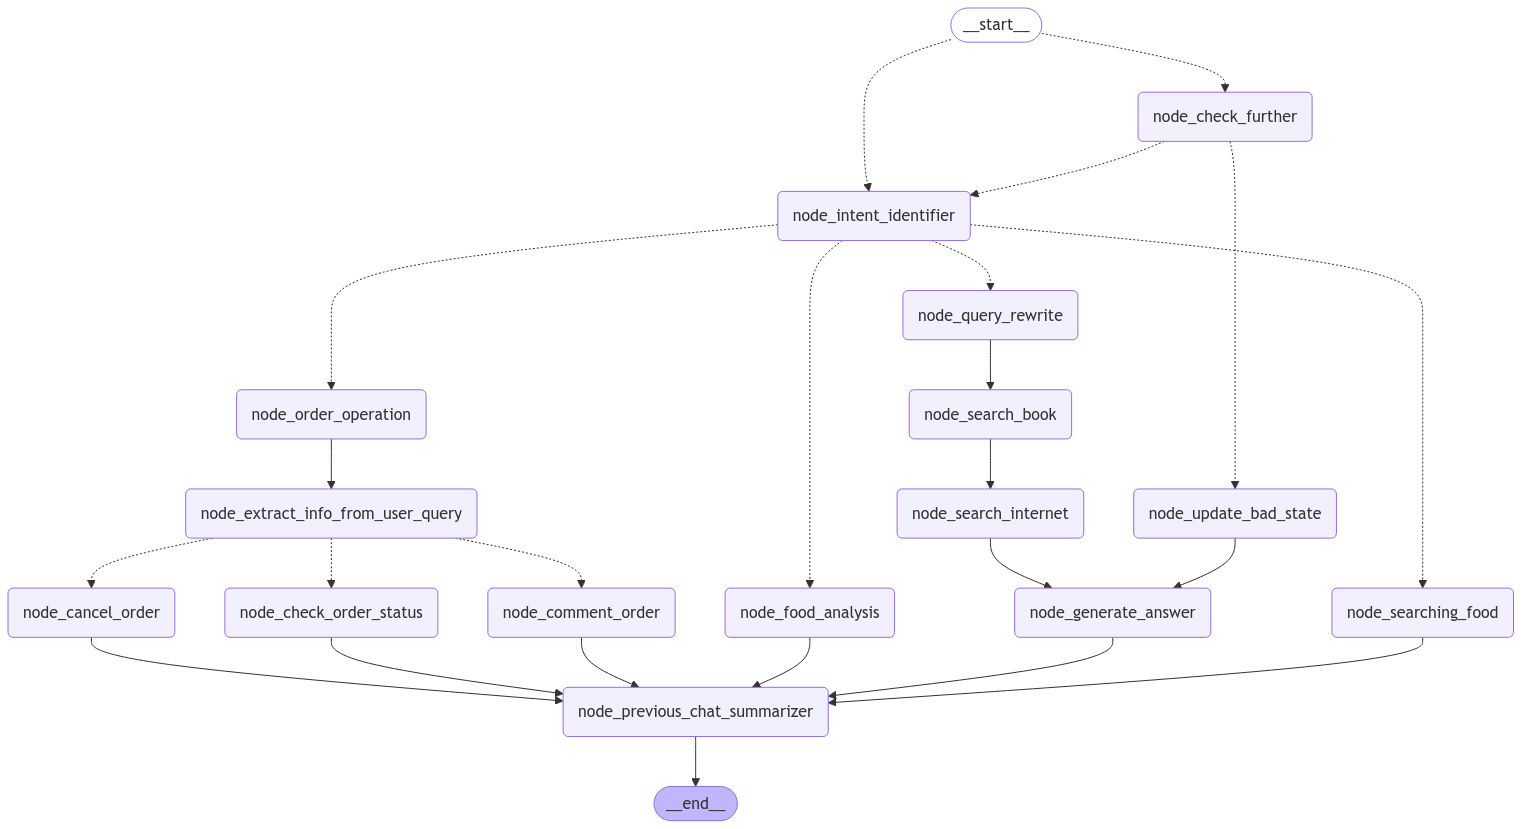

In [68]:
from langgraph.graph import StateGraph, START, END

# Build the graph
builder = StateGraph(MyState)

# Add nodes
builder.add_node("node_query_rewrite", node_query_rewrite)
builder.add_node("node_search_book", node_search_book)
builder.add_node("node_search_internet", node_search_internet)
builder.add_node("node_generate_answer", node_generate_answer)
builder.add_node("node_update_bad_state", node_update_bad_state)
builder.add_node("node_intent_identifier", node_intent_identifier)
builder.add_node("node_order_operation", node_order_operation)
builder.add_node("node_extract_info_from_user_query", node_extract_info_from_user_query)
builder.add_node("node_cancel_order", node_cancel_order)
builder.add_node("node_check_order_status", node_check_order_status)
builder.add_node("node_comment_order", node_comment_order)
builder.add_node("node_searching_food", node_searching_food)
builder.add_node("node_previous_chat_summarizer", node_previous_chat_summarizer)
builder.add_node("node_check_further", node_check_further)
builder.add_node("node_food_analysis", node_food_analysis)

# Add edges (linear flow)
builder.add_conditional_edges(START, is_related)
builder.add_conditional_edges("node_intent_identifier", function_switcher)
builder.add_conditional_edges("node_extract_info_from_user_query", order_operation_switcher)
builder.add_conditional_edges("node_check_further", is_further_related)

builder.add_edge("node_update_bad_state", "node_generate_answer")

builder.add_edge("node_query_rewrite", "node_search_book")
builder.add_edge("node_search_book", "node_search_internet")
builder.add_edge("node_search_internet", "node_generate_answer")
builder.add_edge("node_generate_answer", "node_previous_chat_summarizer")
builder.add_edge("node_order_operation", "node_extract_info_from_user_query")
builder.add_edge("node_comment_order", "node_previous_chat_summarizer")
builder.add_edge("node_check_order_status", "node_previous_chat_summarizer")
builder.add_edge("node_cancel_order", "node_previous_chat_summarizer")
builder.add_edge("node_searching_food", "node_previous_chat_summarizer")
builder.add_edge("node_food_analysis", "node_previous_chat_summarizer")
builder.add_edge("node_previous_chat_summarizer", END)


# Compile the graph
advanced_search_graph = builder.compile()

from IPython.display import Image, display

display(Image(advanced_search_graph.get_graph().draw_mermaid_png()))

In [69]:
os.environ["LANGCHAIN_TRACING_V2"] = "false"  # Disables logging to LangSmith
os.environ["LANGCHAIN_ENABLED"] = "no"        # Disables all LangChain telemetry

In [ ]:
state = {
    "user_query": "I'm craving a spicy fast food meal. What do you recommend?",
    "rewritten_query": None,
    "need_internet_search": None,
    "search_results": None,
    "bad_state": None,
    "final_answer": None,
    "previous_chats_summary": None,
}

print("initial state:")
print(state)

final_state = advanced_search_graph.invoke(state)

print("final answer:")
print(final_state['final_answer'])
state = final_state

print("----------------------------------")
print("final state:")
print(final_state)

In [27]:
"""# write your query here
state['user_query'] = "I'm craving a spicy fast food meal. What do you recommend?"

final_state = advanced_search_graph.invoke(state)

print(final_state['final_answer'])

state = final_state"""

'# write your query here\nstate[\'user_query\'] = "I\'m craving a spicy fast food meal. What do you recommend?"\n\nfinal_state = advanced_search_graph.invoke(state)\n\nprint(final_state[\'final_answer\'])\n\nstate = final_state'